# Cash Buffer Impact Analysis

This notebook investigates the hypothesis that **Cash Buffers harm portfolio performance** more than they help, even for retirees concerned with volatility.

We will simulate different `buffer_years` (0 to 5) and compare:
1.  **Terminal Wealth:** Does the cash drag significantly reduce final portfolio value?
2.  **Success Rate / Survival:** Does the buffer actually prevent ruin in worst-case scenarios?
3.  **Downside Protection:** Look at the 1st and 5th percentile outcomes.

**Simulation Parameters:**
*   Model: AR(1) (Calibrated to full history)
*   Horizon: 30 Years
*   Initial Net Worth: $1,000,000
*   Annual Spend: $40,000 (4% rule)
*   Panic Threshold: -15% (Market drop triggering cash usage)
*   Paths: 2,000

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from simulator import MeanRevertingMarket, run_simulation, get_sp500_data
import warnings
warnings.filterwarnings('ignore')

2025-11-30 15:40:48.072 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-11-30 15:40:48.072 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [5]:
# 1. Setup Simulation
history = get_sp500_data(history_years=60)
model = MeanRevertingMarket(ar_order=3)
model.calibrate_from_history(history)

base_params = {
    "initial_net_worth": 1_000_000,
    "annual_spend": 40_000,
    "years": 60,
    "panic_threshold": -0.15,
    "inflation_rate": 0.03,
    "n_paths": 5000,
    "market_model": model
}

buffer_options = [0, 1, 2, 3, 5]
results = {}

In [6]:
# 2. Run Simulations
np.random.seed(42) # Shared seed for fair comparison across buffers

for buf in buffer_options:
    print(f"Simulating Buffer: {buf} years...")
    # We must reset seed inside the loop or pass same seed to ensure 
    # the MARKET returns are identical for every buffer scenario.
    # However, the simulator generates market matrix internally.
    # To strictly control this, we'd need to pass the matrix, but 
    # re-seeding right before the call works if the calls are identical order.
    np.random.seed(42) 
    
    sim_out = run_simulation(
        buffer_years=buf,
        **base_params
    )
    results[buf] = sim_out["portfolio_values"][-1, :] # Terminal values

Simulating Buffer: 0 years...
Simulating Buffer: 1 years...
Simulating Buffer: 2 years...
Simulating Buffer: 3 years...
Simulating Buffer: 5 years...


In [7]:
# 3. Analyze Results
metrics = []

for buf, terminal_values in results.items():
    # Success: Portfolio > 0
    success_rate = np.mean(terminal_values > 0)
    
    metrics.append({
        "Buffer Years": str(buf),
        "Median Wealth": np.median(terminal_values),
        "Top 25% Wealth": np.percentile(terminal_values, 75),
        "Bottom 25% Wealth": np.percentile(terminal_values, 25),
        "Worst 5% Wealth": np.percentile(terminal_values, 5),
        "Success Rate": success_rate
    })

metrics_df = pd.DataFrame(metrics)
metrics_df.style.format({
    "Median Wealth": "${:,.0f}",
    "Top 25% Wealth": "${:,.0f}",
    "Bottom 25% Wealth": "${:,.0f}",
    "Worst 5% Wealth": "${:,.0f}",
    "Success Rate": "{:.1%}"
})

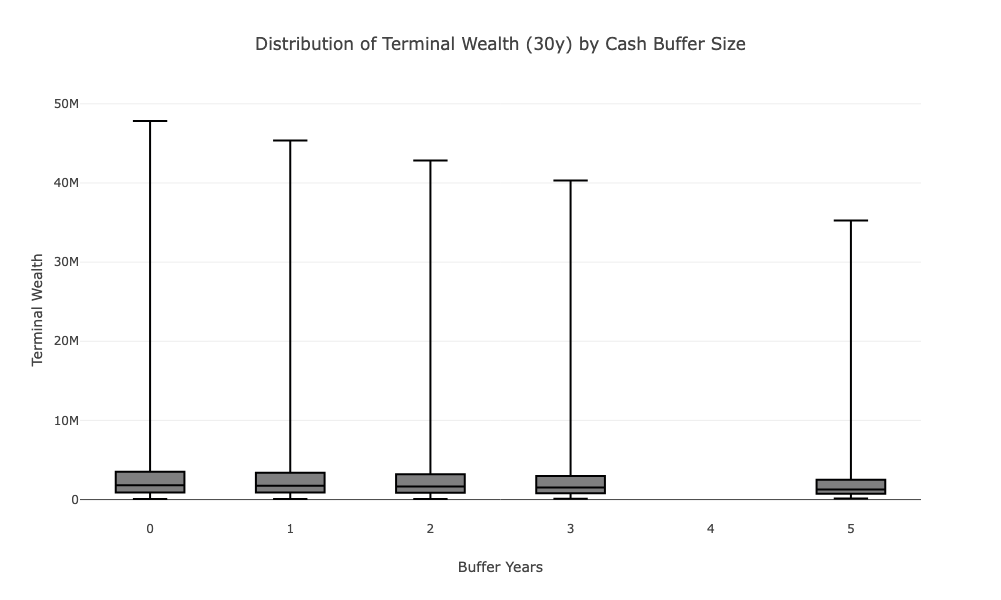

In [8]:
# 4. Visualization: Box Plots of Terminal Wealth
# Reshape for Plotly
plot_data = []
for buf, values in results.items():
    for v in values:
        plot_data.append({"Buffer Years": str(buf), "Terminal Wealth": v})
        
df_plot = pd.DataFrame(plot_data)

fig = px.box(
    df_plot, 
    x="Buffer Years", 
    y="Terminal Wealth", 
    title="Distribution of Terminal Wealth (30y) by Cash Buffer Size",
    points=False # Hide outliers for cleaner view of mass
)
fig.update_layout(height=600)
fig.show()

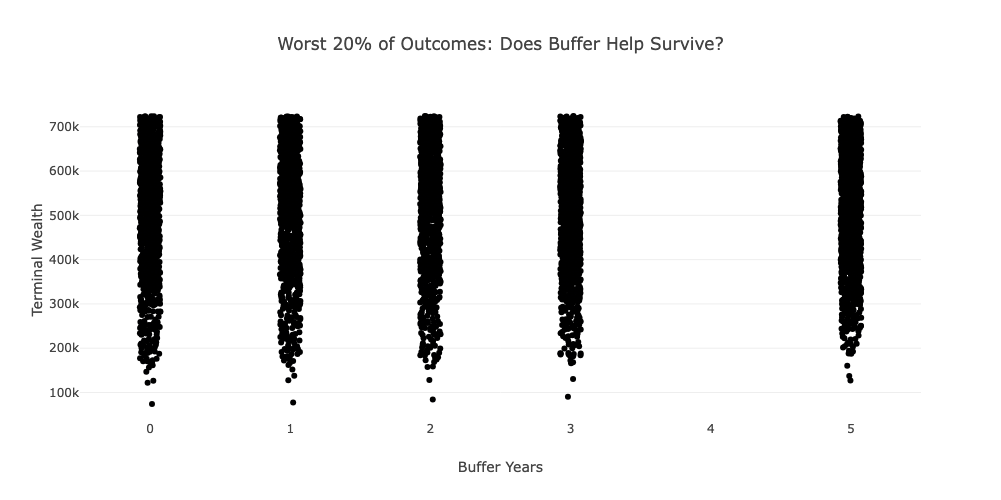

In [9]:
# 5. Downside Focus (Tail Risk)
# Zooming in on the worst 10% outcomes to see if buffer helps THERE.
fig2 = px.strip(
    df_plot[df_plot["Terminal Wealth"] < df_plot["Terminal Wealth"].quantile(0.2)], 
    x="Buffer Years", 
    y="Terminal Wealth",
    title="Worst 20% of Outcomes: Does Buffer Help Survive?"
)
fig2.update_layout(height=500)
fig2.show()